# Crash Predictive ML Model

We will create a tree based model to predict the daily number of crashes at a known intersection using the following:
- weather (temp, snow, rain, precip)
- day of week (Mon, Tues...)
- intersection characteristics
    - speed limit
    - volume of traffic
    - region
    - lanes/ways/turns/split/exit etc.
- violations (may want a violations independent model)
- red light cam present

This time we will look at whole city, and use only global variables for city.

In [2]:

import pandas as pd
import numpy as np

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import plotly_express as px
import plotly

import warnings
warnings.filterwarnings('ignore')


# Decision Tree
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from modules.myfuncs import *

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from boruta import BorutaPy

import pandas as pd
import numpy as np
import itertools

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE, ADASYN

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Decision Tree
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support


In [3]:
conn = create_connection('database/rlc2.db')  # function from myfuncs file
c = conn.cursor()

sqlite3 version: 2.6.0
connected to database/rlc2.db



We will try to get data that is daily for all of the above info.  

In [4]:
print(sql_fetch_tables(c, conn))



def table_info(c, conn):
    '''
    prints out all of the columns of every table in db
    c : cursor object
    conn : database connection object
    '''
    tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    for table_name in tables:
        table_name = table_name[0]
        table = pd.read_sql_query("SELECT * from {} LIMIT 0".format(table_name), conn)
        print(table_name)
        for col in table.columns:
            print('\t' + col)
        print()

table_info(c, conn)


[('cam_locations',), ('cam_startend',), ('daily_violations',), ('all_crashes',), ('hourly_congestion',), ('hourly_weather',), ('region_data',), ('intersection_cams',), ('signal_crashes',), ('int_startend',), ('intersection_chars',), ('all_hours',)]
cam_locations
	camera_id
	intersection
	address
	violation_date
	violations
	latitude
	longitude
	month
	day
	weekday
	year

cam_startend
	camera_id
	start
	end

daily_violations
	intersection
	camera_id
	address
	violation_date
	violations
	latitude
	longitude
	month
	day
	weekday
	year

all_crashes
	crash_record_id
	rd_no
	crash_date
	posted_speed_limit
	traffic_control_device
	device_condition
	weather_condition
	lighting_condition
	first_crash_type
	trafficway_type
	alignment
	roadway_surface_cond
	road_defect
	report_type
	crash_type
	damage
	prim_contributory_cause
	sec_contributory_cause
	street_no
	street_direction
	street_name
	beat_of_occurrence
	num_units
	most_severe_injury
	injuries_total
	injuries_fatal
	injuries_incapacitating

## Query our data
I would like to get hourly intersection data with the following columns:


signal_crashes
	-crash_date
	-posted_speed_limit
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-most_severe_injury
	-injuries_total
	-injuries_fatal
	-injuries_incapacitating
	-injuries_non_incapacitating
	-injuries_reported_not_evident
	-injuries_no_indication
	-injuries_unknown
	-latitude
	-longitude
	-lane_cnt
	-work_zone_i
	-work_zone_type
	-workers_present_i
	-intersection
	-year
	-month
	-day
	-hour
	-region_id
	-time
	-weekday

hourly_weather
	-temp
	-rain_1h
	-rain_3h
	-snow_1h
	-snow_3h
	-time
	-year
	-month
	-day
	-hour
	-weekday

hourly_congestion
	-year
	-month
	-day
	-hour
	-region_id
	-bus_count
	-num_reads
	-speed
	-weekday
    
Tables will be queried to JOIN on year, month, day, hour

WHAT I REALLY NEED HERE
A single dataset with the following:
- daily intersection chars (all the stuff I entered)
- daily intersection crashes (injuries, deaths, number etc)
- daily wx (temp, precip mainly)
- daily congestion (might not need this)
- daily violations (already in the format)

In [5]:
# Approximately how many entries should I expect to be looking at after filtering my data
# 3 years, 4 months x 153 intersections
print((365.25*3 + 30*4) *153)


186009.75


## Query my db to get a DataFrame with crashes and intersection


In [6]:
# This one groups by day for the whole city

all_df = pd.read_sql_query('''WITH ah AS(SELECT year,
                                                month,
                                                day,
                                                intersection  
                                        FROM all_hours
                                        ), 
                                    
                                    ic AS(SELECT intersection,
                                                region_id
                                        FROM intersection_cams
                                        ),
                                    
                                    ich AS(SELECT intersection,
                                                protected_turn,
                                                total_lanes,
                                                medians,
                                                exit,
                                                split,
                                                way,
                                                underpass,
                                                no_left,
                                                angled,
                                                triangle,
                                                one_way,
                                                turn_lanes,
                                                lat,
                                                long,
                                                rlc,
                                                daily_traffic,
                                                speed
                                            FROM intersection_chars
                                        ),
                                
                                    cg AS(SELECT year,
                                                  month,
                                                  day,
                                                  region_id,
                                                  AVG(speed) as speed,
                                                  MAX(speed) as max_speed,
                                                  MIN(speed) as min_speed
                                                    
                                             FROM hourly_congestion
                                            WHERE hour > 6 AND hour < 20
                                             GROUP BY year, month, day, region_id
                                         ),
                                         
                                    v AS(SELECT year,
                                                month,
                                                day,
                                                intersection,
                                                violations,
                                                violation_date
                                            FROM daily_violations
                                                ),
                                                
                                    wx AS(SELECT SUM(snow_1h + rain_1h) AS precip,
                                                SUM(snow_1h) as snow_1h,
                                                SUM(rain_1h) as rain_1h,
                                                MAX(temp) as temp,
                                                year,
                                                month,
                                                day
                                            FROM hourly_weather
                                            GROUP BY year, month, day
                                        ),
                                        
                                    cr AS(SELECT SUM(injuries_total) AS injuries,
                                                year,
                                                month,
                                                day,
                                                intersection,
                                                COUNT(DISTINCT crash_record_id) AS n_crash,
                                                SUM(COALESCE(injuries_total,0)) AS injuries,
                                                SUM(injuries_fatal) AS injuries_fatal,
                                                SUM(injuries_incapacitating) AS injuries_incapacitating
                                         FROM signal_crashes
                                         GROUP BY year, month, day, intersection
                                        )
                                        
                                    SELECT ah.year,
                                        ah.month,
                                        ah.day,
                                        ah.intersection,
                                        
                                        ic.region_id,
                                        
                                        cg.speed,
                                        cg.min_speed,
                                        cg.max_speed,
                                        
                                        v.violations,
                                        v.violation_date,
                                        
                                        wx.snow_1h,
                                        wx.rain_1h,
                                        wx.precip,
                                        wx.temp,
                                        
                                        cr.n_crash,
                                        cr.injuries,
                                        cr.injuries_fatal,
                                        cr.injuries_incapacitating,
                                        protected_turn,
                                        
                                        ich.total_lanes,
                                        ich.medians,
                                        ich.exit,
                                        ich.split,
                                        ich.way,
                                        ich.underpass,
                                        ich.no_left,
                                        ich.angled,
                                        ich.triangle,
                                        ich.one_way,
                                        ich.turn_lanes,
                                        ich.lat,
                                        ich.long,
                                        ich.rlc,
                                        ich.intersection,
                                        ich.daily_traffic,
                                        ich.speed as speed_limit
                                                                           
                                    FROM ah
                                    LEFT JOIN ic
                                        ON ic.intersection = ah.intersection
                                    LEFT JOIN cg
                                        ON cg.year = ah.year
                                        AND cg.month = ah.month
                                        AND cg.day = ah.day
                                        AND cg.region_id = ic.region_id
                                    LEFT JOIN v
                                        ON v.year = ah.year
                                        AND v.month = ah.month
                                        AND v.day = ah.day
                                        AND v.intersection = ah.intersection
                                    LEFT JOIN wx
                                        ON wx.year = ah.year
                                        AND wx.month = ah.month
                                        AND wx.day = ah.day
                                    LEFT JOIN cr
                                        ON cr.year = ah.year
                                        AND cr.month = ah.month
                                        AND cr.day = ah.day
                                        AND cr.intersection = ah.intersection
                                    LEFT JOIN ich
                                        ON ich.intersection = ah.intersection
                                    
                                    WHERE v.violation_date >= \'2017-09-01\' 
                                            AND v.violation_date < \'2020-12-01\'
                                    
                                    GROUP BY ah.year, ah.month, ah.day, ah.intersection
                                    ORDER BY ah.year, ah.month, ah.day
                                    ''', conn)

In [7]:
len(all_df.violations.unique())

59

In [8]:
pd.options.display.max_rows = 153
pd.options.display.max_columns = 200

all_df.describe()

,year,month,day,speed,min_speed,max_speed,violations,snow_1h,rain_1h,precip,temp,n_crash,injuries,injuries_fatal,injuries_incapacitating,protected_turn,total_lanes,medians,exit,split,way,underpass,no_left,angled,triangle,one_way,turn_lanes,lat,long,rlc,daily_traffic,speed_limit
count,170799.000000,170799.000000,170799.000000,168065.000000,168065.000000,168065.000000,170799.000000,170799.000000,170799.000000,170799.000000,170799.000000,5389.000000,5388.000000,5388.000000,5388.000000,170799.000000,170799.000000,170799.000000,170799.000000,170799.000000,170799.000000,170799.000000,170799.000000,170799.000000,170799.000000,170799.000000,170799.000000,170799.000000,170799.000000,170799.0,170799.000000,170799.000000
mean,2018.771913,6.795912,15.723453,22.560603,20.549538,24.628124,3.667047,0.202742,2.670225,2.872968,290.267183,1.029133,0.393838,0.001856,0.042502,2.140838,6.587761,0.399030,0.122296,0.047881,4.119614,0.136289,0.253649,0.150405,0.183157,0.218742,3.261787,41.886804,-87.700111,1.0,51081.425535,35.675209
std,0.970023,3.433356,8.796648,3.254207,3.863928,3.119676,3.728732,0.955728,6.180053,6.269083,11.562653,0.178891,0.872222,0.050945,0.247979,1.604021,1.826347,0.749885,0.327628,0.213515,0.476649,0.446190,0.636088,0.357469,0.386796,0.574829,1.294333,0.079972,0.050662,0.0,14436.820482,3.574141
min,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,255.370000,1.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.677774,-87.812226,1.0,21600.000000,30.000000
25%,2018.000000,4.000000,8.000000,20.501154,18.296667,22.615000,1.000000,0.000000,0.000000,0.000000,280.930000,1.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,41.830281,-87.742870,1.0,41800.000000,35.000000
50%,2019.000000,7.000000,16.000000,22.291897,20.455000,24.456667,2.000000,0.000000,0.000000,0.120000,290.370000,1.000000,0.000000,0.000000,0.000000,2.000000,6.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,41.909627,-87.701308,1.0,49200.000000,35.000000
75%,2020.000000,10.000000,23.000000,24.522692,22.953333,26.588333,4.000000,0.000000,2.030000,2.500000,300.370000,1.000000,1.000000,0.000000,0.000000,4.000000,8.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,41.946624,-87.663034,1.0,58200.000000,35.000000
max,2020.000000,12.000000,31.000000,33.855000,32.730000,39.841667,126.000000,11.650000,53.010000,53.010000,310.370000,3.000000,21.000000,2.000000,5.000000,4.000000,14.000000,3.000000,1.000000,1.000000,6.000000,2.000000,3.000000,1.000000,1.000000,3.000000,6.000000,42.012234,-87.575373,1.0,105500.000000,65.000000


In [9]:
all_df['speed'] = all_df.speed.fillna(all_df.speed.mean())
all_df['min_speed'] = all_df.speed.fillna(all_df.min_speed.mean())
all_df['max_speed'] = all_df.speed.fillna(all_df.max_speed.mean())


all_df['violation_date'] = pd.to_datetime(all_df['violation_date'])
all_df['weekday'] = all_df['violation_date'].apply(lambda x: x.strftime("%A"))
all_df['month'] = all_df['violation_date'].apply(lambda x: x.strftime("%b"))
#all_df["violation_date"] = all_df["violation_date"].dt.strftime('%Y-%m')


In [10]:
y = all_df['n_crash'].fillna(0).astype(bool)

drop_cols = ['injuries', 'injuries_fatal', 'injuries_incapacitating', 'n_crash', 'violation_date',
            'day']


X = all_df.drop(columns=drop_cols) 


In [11]:

X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170799 entries, 0 to 170798
Data columns (total 31 columns):
year              170799 non-null int64
month             170799 non-null object
intersection      170799 non-null object
region_id         170799 non-null object
speed             170799 non-null float64
min_speed         170799 non-null float64
max_speed         170799 non-null float64
violations        170799 non-null int64
snow_1h           170799 non-null float64
rain_1h           170799 non-null float64
precip            170799 non-null float64
temp              170799 non-null float64
protected_turn    170799 non-null int64
total_lanes       170799 non-null int64
medians           170799 non-null int64
exit              170799 non-null int64
split             170799 non-null int64
way               170799 non-null int64
underpass         170799 non-null int64
no_left           170799 non-null int64
angled            170799 non-null int64
triangle          170799 non-nul

In [12]:
X = pd.get_dummies(X)
print(len(X.columns))
#X = X.drop(columns=boruta_drop) 



376


In [13]:
y.sum()/y.count()

0.031551706977207127

### Train test split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
X.describe()

,year,speed,min_speed,max_speed,violations,snow_1h,rain_1h,precip,temp,protected_turn,total_lanes,medians,exit,split,way,underpass,no_left,angled,triangle,one_way,turn_lanes,lat,long,rlc,daily_traffic,speed_limit,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,intersection_115TH AND HALSTED,intersection_119TH AND HALSTED,intersection_31ST ST AND MARTIN LUTHER KING DRIVE,intersection_35TH AND WESTERN,intersection_4700 WESTERN,intersection_55TH AND KEDZIE,intersection_55TH AND WESTERN,intersection_55TH and PULASKI,intersection_63RD AND STATE,intersection_71ST AND ASHLAND,intersection_75TH AND STATE,intersection_79TH AND HALSTED,intersection_79TH AND KEDZIE,intersection_87TH AND VINCENNES,intersection_99TH AND HALSTED,intersection_ADDISON AND HARLEM,intersection_ARCHER AND CICERO,intersection_ASHLAND AND 87TH,intersection_ASHLAND AND 95TH,intersection_ASHLAND AND DIVISION,intersection_ASHLAND AND FULLERTON,intersection_ASHLAND AND IRVING PARK,intersection_ASHLAND AND LAWRENCE,intersection_ASHLAND AND MADISON,intersection_AUSTIN AND ADDISON,intersection_AUSTIN AND IRVING PARK,intersection_BELMONT AND KEDZIE,intersection_BROADWAY/SHERIDAN AND DEVON,intersection_CALIFORNIA AND DEVON,intersection_CALIFORNIA AND DIVERSEY,intersection_CALIFORNIA AND PETERSON,intersection_CANAL AND ROOSEVELT,intersection_CENTRAL AND ADDISON,intersection_CENTRAL AND BELMONT,intersection_CENTRAL AND CHICAGO,intersection_CENTRAL AND DIVERSEY,intersection_CENTRAL AND FULLERTON,intersection_CENTRAL AND IRVING PARK,intersection_CENTRAL AND LAKE,intersection_CENTRAL AND MILWAUKEE,intersection_CERMAK AND PULASKI,intersection_CHICAGO AND CLARK,intersection_CICERO AND 47TH,intersection_CICERO AND ADDISON,intersection_CICERO AND ARMITAGE,intersection_CICERO AND CHICAGO,intersection_CICERO AND DIVERSEY,intersection_CICERO AND FULLERTON,intersection_CICERO AND HARRISON,intersection_CICERO AND I55,intersection_CICERO AND NORTH,intersection_CICERO AND PETERSON,intersection_CICERO AND WASHINGTON,intersection_CLARK AND FULLERTON,intersection_CLARK AND IRVING PARK,intersection_COLUMBUS AND ILLINOIS,intersection_CORTLAND AND ASHLAND,intersection_COTTAGE GROVE AND 71ST,intersection_DAMEN AND 63RD,intersection_DAMEN AND DIVERSEY,intersection_DAMEN AND ELSTON,intersection_DAMEN AND FULLERTON,...,intersection_DAMEN AND DIVERSEY,intersection_DAMEN AND ELSTON,intersection_DAMEN AND FULLERTON,intersection_DIVERSEY AND AUSTIN,intersection_DIVERSEY AND WESTERN,intersection_DIVISION AND DAMEN,intersection_ELSTON AND ADDISON,intersection_ELSTON AND IRVING PARK,intersection_ELSTON AND LAWRENCE,intersection_FOSTER AND BROADWAY,intersection_FOSTER AND NAGLE,intersection_FOSTER AND NORTHWEST HIGHWAY,intersection_FULLERTON AND NARRAGANSETT,intersection_HALSTED AND 103RD,intersection_HALSTED AND 95TH,intersection_HALSTED AND DIVISION,intersection_HALSTED AND FULLERTON,intersection_HALSTED AND MADISON,intersection_HALSTED AND NORTH,intersection_HAMLIN AND LAKE,intersection_HAMLIN AND MADISON,intersection_HARLEM AND BELMONT,intersection_HOLLYWOOD AND SHERIDAN,intersection_HOMAN/KIMBALL AND NORTH,intersection_IRVING PARK AND CALIFORNIA,intersection_IRVING PARK AND KILPATRICK,intersection_IRVING PARK AND LARAMIE,intersection_IRVING PARK AND NARRAGANSETT,intersection_JEFFERY AND 95TH,intersection_KEDZIE AND 26TH,intersection_KEDZIE AND 31ST,intersection_KEDZIE AND 47TH,intersection_KEDZIE AND 63RD,intersection_KEDZIE AND 71ST,intersection_KEDZIE AND ARMITAGE,intersection_KIMBALL AND DIVERSEY,intersection_KOSTNER AND NORTH,intersection_LAFAYETTE AND 87TH,intersection_LAKE AND UPPER WACKER,intersection_LAKE SHORE DR AND BELMONT,intersection_LARAMIE AND FULLERTON,intersection_LARAMIE AND MADISON,intersection_LASALLE AND KINZIE,intersection_LAWRENCE AND CICERO,intersection_LAWRENCE AND WESTERN,intersection_MADISON AND WESTERN,intersection_MICHIGAN AND JACKSON,intersection_MICHIGAN AND ONTARIO,intersection_MILWAUKEE AND CENTRAL

In [16]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(fit_intercept=False, solver='liblinear')


rfe = RFE(logreg)
rfe = rfe.fit(X, y)  # convert to bool before using in logistic so I can do binary

In [17]:
auto_drop = []

for i in range(len(X.columns)):
    if rfe.support_[i]:
        print('Use: ', rfe.ranking_[i], X.columns[i])
    else:
        print('Elim:', rfe.ranking_[i], X.columns[i])
        auto_drop.append(X.columns[i])

Use:  1 year
Use:  1 speed
Use:  1 min_speed
Use:  1 max_speed
Use:  1 violations
Use:  1 snow_1h
Use:  1 rain_1h
Use:  1 precip
Use:  1 temp
Use:  1 protected_turn
Use:  1 total_lanes
Use:  1 medians
Use:  1 exit
Use:  1 split
Use:  1 way
Elim: 7 underpass
Use:  1 no_left
Use:  1 angled
Use:  1 triangle
Use:  1 one_way
Use:  1 turn_lanes
Use:  1 lat
Use:  1 long
Use:  1 rlc
Use:  1 daily_traffic
Use:  1 speed_limit
Use:  1 month_Apr
Use:  1 month_Aug
Use:  1 month_Dec
Use:  1 month_Feb
Use:  1 month_Jan
Elim: 14 month_Jul
Use:  1 month_Jun
Use:  1 month_Mar
Use:  1 month_May
Use:  1 month_Nov
Use:  1 month_Oct
Elim: 94 month_Sep
Elim: 179 intersection_115TH AND HALSTED
Elim: 83 intersection_119TH AND HALSTED
Elim: 52 intersection_31ST ST AND MARTIN LUTHER KING DRIVE
Use:  1 intersection_35TH AND WESTERN
Use:  1 intersection_4700 WESTERN
Use:  1 intersection_55TH AND KEDZIE
Elim: 151 intersection_55TH AND WESTERN
Elim: 116 intersection_55TH and PULASKI
Use:  1 intersection_63RD AND STA

In [18]:
# accept the RFE results automatically
X = X.drop(columns=auto_drop) 

### Train test split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


AUC: 0.5232907914980266


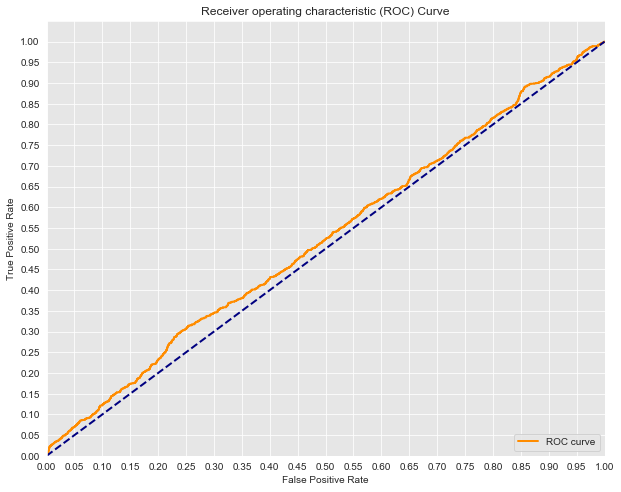

In [20]:
# Initial Model
logreg = LogisticRegression(fit_intercept=False, solver='liblinear')

# Probability scores for test set
y_score = logreg.fit(X_train, y_train).decision_function(X_test)
# False positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Print AUC
print('AUC: {}'.format(auc(fpr, tpr)))

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [21]:
#SMOTE
# Previous original class distribution
print(y_train.value_counts()) 

# Fit SMOTE to training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train) 

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts()) 

# Note, if you get an Attribute Error: 'SMOTE' object has no attribute
# '_validate_data', then downgrade your version of imblearn to 0.6.2
# or upgrade your version of sklearn to 0.23

False    132371
True       4268
Name: n_crash, dtype: int64


True     132371
False    132371
dtype: int64


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.01: 0.6009762635831754
-------------------------------------------------------
LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.05: 0.58267909746541
-------------------------------------------------------
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
             

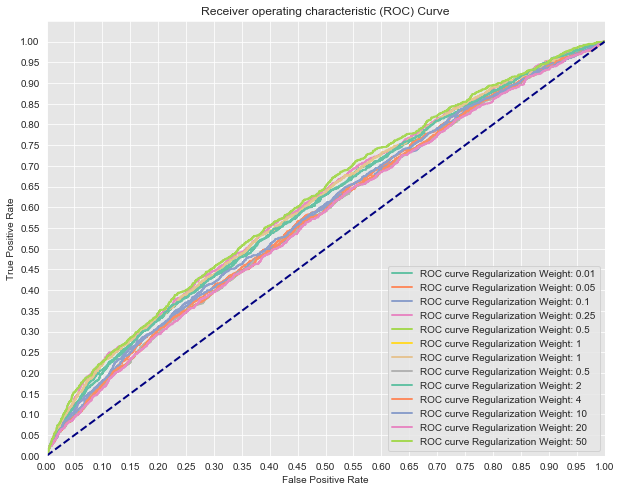

In [22]:
# SMOTE OVERSAMPLING

# Now let's compare a few different regularization performances on the dataset
C_param_range = [0.01, 0.05, 0.1, 0.25, 0.5, 1, 1,.5, 2, 4, 10, 20, 50]
names = [0.01, 0.05, 0.1, 0.25, 0.5, 1, 1,.5, 2, 4, 10, 20, 50]
colors = sns.color_palette('Set2', n_colors=len(names))

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log) # Preview model params

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train_resampled, y_train_resampled).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------')
    
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Regularization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 50: 0.6107948708955564
-------------------------------------------------------


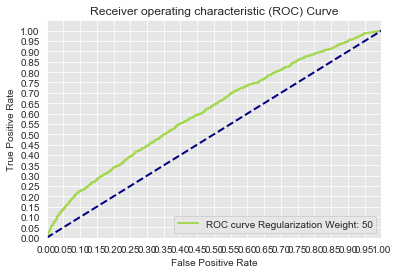

In [23]:
# Fit a model
logreg = LogisticRegression(fit_intercept=False, C=0.1, solver='liblinear')

# Fit SMOTE to training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train) 

model_log = logreg.fit(X_train_resampled, y_train_resampled)
print(model_log) # Preview model params

# Predict
y_hat_test = logreg.predict(X_test)

y_score = logreg.fit(X_train_resampled, y_train_resampled).decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
print('-------------------------------------------------------')

lw = 2
plt.plot(fpr, tpr, color=colors[n], lw=lw, label='ROC curve Regularization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [26]:
decisions = logreg.predict(X_test)
cm = confusion_matrix(decisions, y_test.astype(int))
#y2_test.unique()
cm

array([[20743,   537],
       [12296,   584]])

In [27]:
# Machine learning improvement
n = cm[0].sum() + cm[1].sum()  # all test 

p0 = y_test.sum() / len(y_test)  # what is the guess rate I would use if I didn't know anything else
p1 = 1 - p0

guessing = p0**2 + p1**2

print('Probability with guessing: {:.3f}'.format(guessing))

ml = (cm[1][1] + cm[0][0]) / n
print('Probability with machine learning: {:.3f}'.format(ml))

increase = (ml - guessing) / guessing
print('\nPercent increase: {:.2%}'.format(increase))

Probability with guessing: 0.937
Probability with machine learning: 0.624

Percent increase: -33.34%


In [28]:
probs = logreg.predict_proba(X)
probs.shape[:5]
probs[:5]

array([[0.41695706, 0.58304294],
       [0.40841678, 0.59158322],
       [0.38281045, 0.61718955],
       [0.3167257 , 0.6832743 ],
       [0.23578196, 0.76421804]])

In [ ]:
# let's look at a single intersection
X_int = X[X['intersection_75TH AND STATE']==1]

y_int = all_df[all_df['intersection']=='75TH AND STATE']['n_crash'].astype(bool).astype(int)
y_prob = logreg.predict_proba(X_int)



In [ ]:
import plotly.express as px


fig = px.line(all_df2, x='violation_date', y='prob', width=1000, height=400,) # hover_data=[]
fig.add_scatter(x=all_df2.violation_date, y=all_df2.n_crash, mode='markers', name='model predict')

fig.update_layout(legend=dict(
                            yanchor="top",
                            y=0.99,
                            xanchor="left",
                            x=0.01),
                  yaxis_title="Violations",
                 )

fig.update_layout(margin=dict(
                                        l=0, #left margin
                                        r=0, #right margin
                                        b=0, #bottom margin
                                        t=0  #top margin
                                        )
                    )
                    


fig.show()


In [41]:
X.head()

,year,speed,min_speed,max_speed,violations,snow_1h,rain_1h,precip,temp,protected_turn,total_lanes,medians,exit,split,way,no_left,angled,triangle,one_way,turn_lanes,lat,long,rlc,daily_traffic,speed_limit,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jun,month_Mar,month_May,month_Nov,month_Oct,intersection_35TH AND WESTERN,intersection_4700 WESTERN,intersection_55TH AND KEDZIE,intersection_63RD AND STATE,intersection_75TH AND STATE,intersection_87TH AND VINCENNES,intersection_99TH AND HALSTED,intersection_ADDISON AND HARLEM,intersection_ASHLAND AND 87TH,intersection_AUSTIN AND ADDISON,intersection_BELMONT AND KEDZIE,intersection_BROADWAY/SHERIDAN AND DEVON,intersection_CALIFORNIA AND DEVON,intersection_CANAL AND ROOSEVELT,intersection_CENTRAL AND ADDISON,intersection_CENTRAL AND DIVERSEY,intersection_CENTRAL AND LAKE,intersection_CHICAGO AND CLARK,intersection_CICERO AND 47TH,intersection_CICERO AND CHICAGO,intersection_CICERO AND DIVERSEY,intersection_CICERO AND FULLERTON,intersection_CLARK AND FULLERTON,intersection_CLARK AND IRVING PARK,intersection_COLUMBUS AND ILLINOIS,intersection_DAMEN AND 63RD,intersection_DAMEN AND ELSTON,intersection_DIVERSEY AND AUSTIN,intersection_DIVERSEY AND WESTERN,intersection_DIVISION AND DAMEN,intersection_ELSTON AND ADDISON,intersection_ELSTON AND LAWRENCE,intersection_FOSTER AND NAGLE,intersection_FOSTER AND NORTHWEST HIGHWAY,intersection_HALSTED AND 95TH,intersection_HALSTED AND MADISON,intersection_HALSTED AND NORTH,intersection_HAMLIN AND LAKE,intersection_HAMLIN AND MADISON,intersection_HOLLYWOOD AND SHERIDAN,intersection_IRVING PARK AND KILPATRICK,intersection_KEDZIE AND 26TH,intersection_KEDZIE AND 47TH,intersection_KEDZIE AND 71ST,intersection_KEDZIE AND ARMITAGE,intersection_LAKE AND UPPER WACKER,intersection_MILWAUKEE AND CENTRAL,intersection_MILWAUKEE AND DEVON,intersection_NORTHWEST HIGHWAY AND FOSTER,intersection_PETERSON AND WESTERN,intersection_PULASKI AND ARMITAGE,intersection_PULASKI AND BELMONT,intersection_ROOSEVELT AND PULASKI,intersection_SACRAMENTO AND CHICAGO,intersection_SACRAMENTO AND LAKE,intersection_SHERIDAN AND FOSTER,intersection_STONEY ISLAND AND 79TH,intersection_STONY ISLAND/CORNELL AND 67TH,intersection_TOUHY AND OSCEOLA,intersection_VAN BUREN AND WESTERN,intersection_WENTWORTH AND GARFIELD,intersection_WESTERN AND FULLERTON,region_id_1,region_id_10,region_id_11,region_id_12,region_id_14,region_id_15,region_id_18,region_id_19,region_id_2,region_id_21,region_id_22,region_id_23,region_id_24,region_id_26,region_id_29,region_id_3,region_id_4,region_id_5,region_id_6,region_id_7,region_id_8,region_id_9,intersection_35TH AND WESTERN,intersection_4700 WESTERN,intersection_55TH AND KEDZIE,intersection_63RD AND STATE,intersection_75TH AND STATE,intersection_87TH AND VINCENNES,intersection_99TH AND HALSTED,intersection_ADDISON AND HARLEM,intersection_ASHLAND AND 87TH,intersection_AUSTIN AND ADDISON,intersection_BELMONT AND KEDZIE,intersection_BROADWAY/SHERIDAN AND DEVON,intersection_CALIFORNIA AND DEVON,intersection_CANAL AND ROOSEVELT,intersection_CENTRAL AND ADDISON,intersection_CENTRAL AND DIVERSEY,intersection_CENTRAL AND LAKE,intersection_CHICAGO AND CLARK,intersection_CICERO AND 47TH,intersection_CICERO AND CHICAGO,intersection_CICERO AND DIVERSEY,intersection_CICERO AND FULLERTON,intersection_CLARK AND FULLERTON,intersection_CLARK AND IRVING PARK,intersection_COLUMBUS AND ILLINOIS,intersection_DAMEN AND 63RD,intersection_DAMEN AND ELSTON,intersection_DIVERSEY AND AUSTIN,intersection_DIVERSEY AND WESTERN,intersection_DIVISION AND DAMEN,intersection_ELSTON AND ADDISON,intersection_ELSTON AND LAWRENCE,intersection_FOSTER AND NAGLE,intersection_FOSTER AND NORTHWEST HIGHWAY,intersection_HALSTED AND 95TH,intersection_HALSTED AND MADISON,intersection_HALSTED AND NORTH,intersection_HAMLIN AND LAKE,intersection_HAMLIN AND MADISON,intersection_HOLLYWOOD AND SHERIDAN,intersection_IRVING PARK AND KILPATRICK,intersection_KEDZIE AND 26TH,intersection_KEDZIE AND 47TH,i